In [1]:
from torch import *
from fastai.basics import *

downloading mnist dataset

In [5]:
!wget https://raw.githubusercontent.com/AnujPanthri/Fast_ai_v3/main/data/mnist.pkl.gz

--2022-08-22 02:33:05--  https://raw.githubusercontent.com/AnujPanthri/Fast_ai_v3/main/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  --.-KB/s    in 0.1s    

2022-08-22 02:33:06 (116 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [6]:
import gzip

path = Path('.')
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

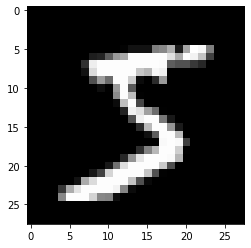

In [7]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [8]:
(x_train,y_train,x_valid,y_valid)=map(torch.tensor,(x_train,y_train,x_valid,y_valid))

In [9]:
x_train.shape,y_train.shape,y_train.min(),y_train.max()

(torch.Size([50000, 784]), torch.Size([50000]), tensor(0), tensor(9))

In [10]:
from torch.utils.data import *
bs=64

train_ds=TensorDataset(x_train,y_train)
valid_ds=TensorDataset(x_valid,y_valid)
data=DataLoaders.from_dsets(train_ds,valid_ds,bs=bs)

In [11]:
data.train.__len__(),data.valid.__len__()

(781, 157)

In [12]:
list(map(lambda x:x.shape,data.train.one_batch()))

[torch.Size([64, 784]), torch.Size([64])]

In [13]:
x,y = next(iter(data.train))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [14]:
class Mnist_Logistic(nn.Module):
  def __init__(self):
    super().__init__()
    self.ln1=nn.Linear(784,10,bias=True)
  def forward(self,xbatch):
    return self.ln1(xbatch)

In [15]:
# model=Mnist_Logistic().cuda()
model=Mnist_Logistic()

In [16]:
model

Mnist_Logistic(
  (ln1): Linear(in_features=784, out_features=10, bias=True)
)

In [17]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [18]:
lr=1e-2
loss_func=nn.CrossEntropyLoss()

In [19]:
def update(x,y,lr):
  wd=0.01
  y_hat=model(x)
  w2=0.0
  for p in model.parameters(): w2+=(p**2).sum()
  loss=loss_func(y_hat,y)+wd*w2
  loss.backward()
  with torch.no_grad():
    for p in model.parameters():
      p.sub_(lr * p.grad)
      p.grad.zero_()
  return loss.item()

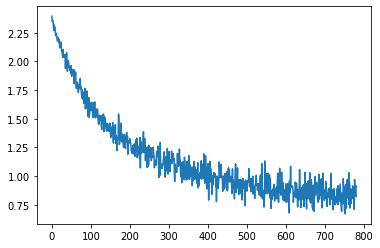

In [20]:
losses=[update(x,y,lr) for x,y in data.train]
plt.plot(losses)

In [21]:
class Mnist_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.ln1=nn.Linear(784,50,bias=True)
    self.ln2=nn.Linear(50,10,bias=True)
  def forward(self,xbatch):
    y_hat=self.ln1(xbatch)
    y_hat=F.relu(y_hat)
    y_hat=self.ln2(y_hat)
    return y_hat

In [22]:
# model=Mnist_NN().cuda()
model=Mnist_NN()

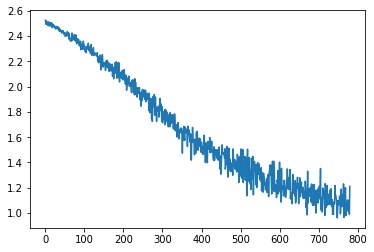

In [23]:
losses=[update(x,y,lr) for x,y in data.train]
plt.plot(losses)

In [24]:
model=Mnist_NN()

In [25]:
from torch import optim
def update(x,y,lr):
  opt = optim.Adam(model.parameters(),lr)
  y_hat = model(x)
  loss = loss_func(y_hat,y)
  loss.backward()
  opt.step()
  opt.zero_grad()
  return loss.item()

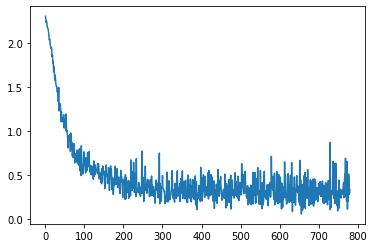

In [26]:
losses=[update(x,y,1e-3) for x,y in data.train]
plt.plot(losses)

In [40]:
import fastai.callback.schedule # To get `fit_one_cycle`, `lr_find`   (IMPORTANT)

learn = Learner(data,Mnist_NN(),loss_func=loss_func,metrics=accuracy)

In [41]:
learn.model

Mnist_NN(
  (ln1): Linear(in_features=784, out_features=50, bias=True)
  (ln2): Linear(in_features=50, out_features=10, bias=True)
)

SuggestedLRs(valley=0.00363078061491251)

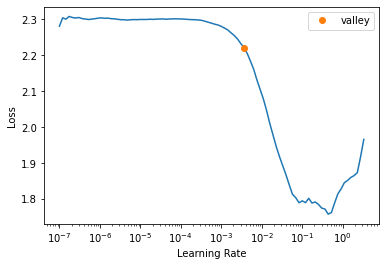

In [42]:
learn.lr_find()

In [43]:
learn.fit_one_cycle(1,lr_max=2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.159441,0.131275,0.962800,00:06


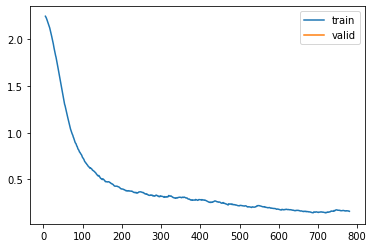

In [44]:
learn.recorder.plot_loss()

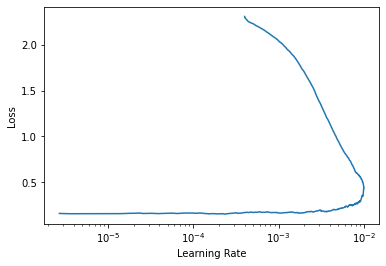

In [34]:
learn.recorder.plot_lr_find()

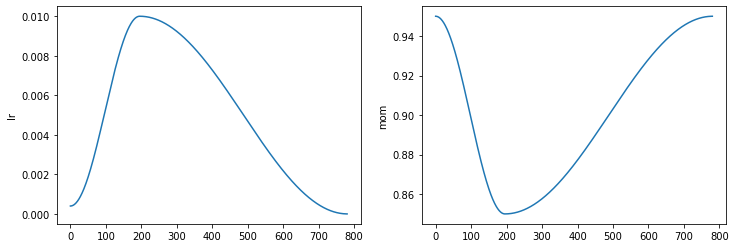

In [35]:
learn.recorder.plot_sched()